### Notebook to visualize all degron-like regions in a scatter plot where the x-axis is the TOP_SCORE of the peak and the y-axis is the mean Stability Change
- Figure 5b

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as clb
%matplotlib inline
import seaborn as sns
from scipy import stats
import matplotlib.colors as clr

### paths

In [3]:
base="../" 

path_output_profile_degrons = os.path.join(base,"data","profile_degrons.pickle")
path_output_peaks = os.path.join(base,"data","peaks_degrons.tsv")
path_output_denovo_degrons = os.path.join(base,"data","de_novo_degrons.tsv")
output_path_plots = os.path.join(base,"plots","Figure4")
output_path_antibodies = os.path.join(base,"data","antibodies_figure4.tsv")

#### Read the degrons

In [4]:
df_degrons = pd.read_csv(path_output_denovo_degrons,sep="\t")

In [5]:
df_degrons.shape

(22, 18)

In [16]:
len(df_degrons["Hugo_Symbol"].unique())

17

#### define functions for visualization

#### Set pallete of z-score

In [5]:
def to_hex(a,b,c):
    return '#%02x%02x%02x' % (int(a*255), int(b*255), int(c*255))
    
my_pallete = []
maxv = np.nanmax(3) 
minv = np.nanmin(0)
norm = clr.Normalize(vmin=minv,vmax=maxv)
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
nanvalue = (maxv+minv) / 2
cmap = plt.cm.Reds
for i in range(plt.cm.Reds.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    my_pallete.append(clr.rgb2hex(rgb))


In [6]:
def set_text(row):
    start = row["DEGRON"].split(":")[1]
    end = row["DEGRON"].split(":")[2]
    if "_p" in row["Protein"]:
        return row["Hugo_Symbol"]+row["Protein"].split("_")[1]+"("+str(start)+"-"+str(end)+")"
    else:
        return row["Hugo_Symbol"]+"("+str(start)+"-"+str(end)+")"
data = df_degrons.copy()
data["Color"] = data.apply(lambda row: to_hex(*sm.to_rgba(row["Zscore"])[0:3]) if np.isfinite(row["Zscore"]) else "#B7B6B7",axis=1) # to_hex(*sm.to_rgba(nanvalue)[0:3])
data["Text"]= data.apply(lambda row: set_text(row),axis=1)
data["lw"]= data.apply(lambda row: 0.3 if str(row["E3s"]) != "nan" else 0.0,axis=1)
data["ec"]= data.apply(lambda row: "black" if str(row["E3s"]) != "nan" else row["Color"],axis=1)



#### Plot the color bar

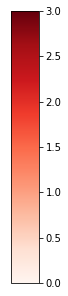

In [21]:
fig,ax = plt.subplots(figsize=(0.5,5))
clb.ColorbarBase(ax=ax,cmap=plt.cm.Reds,orientation="vertical",norm=norm)
plt.savefig(output_path_plots+'/colorbar_denovo_zscores.pdf', dpi=800,bbox_inches="tight")

### For the sake of visualization select only one antibody per protein

In [17]:
def concat_total(grp):
    s = list(grp)
    return ",".join([str(x) for x in list(s)])
s = []
for index,row in data.groupby(["Hugo_Symbol"],as_index=False).agg({"Protein":concat_total,"num_mutations_peak":concat_total}).iterrows():
    if "," in row["Protein"]: # Select the antibody with higher number of samples
        index = np.argmax(row["num_mutations_peak"].split(","))
        s.append([row["Hugo_Symbol"],row["Protein"].split(",")[index]])
    else:
        s.append([row["Hugo_Symbol"],row["Protein"]])
df_antibodies = pd.DataFrame(s,columns=["Hugo_Symbol","Protein"])
df_antibodies.to_csv(output_path_antibodies,sep="\t",index=False)

#### Filter antibodies

In [18]:
data = data.merge(df_antibodies)

In [19]:
data.shape

(19, 22)

In [20]:
data["E3s"].fillna("",inplace=True)
data[data["E3s"]!=""].shape


(5, 22)

#### Visualize

In [21]:
len(data["STD_Stability_Change"].values)

19

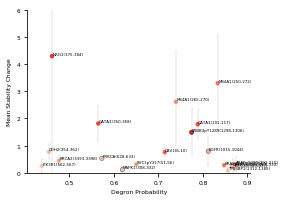

In [22]:
fig,ax = plt.subplots(figsize=(4,3))
ax.scatter(x=data["Prob_TOP"].values,y=data["MEAN_Stability_Change"].values,color=data["Color"].values,s=20,linewidths=data["lw"].values,edgecolors=data["ec"].values)# [x for x in data["Width_Line"].values]
# create the coordinates for the errorbars
err_xs = []
err_ys = []
yerrs = data["STD_Stability_Change"].values
xs = data["Prob_TOP"].values
ys = data["MEAN_Stability_Change"].values
for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))
i = 0
ax.errorbar(xs, ys, yerr= data["STD_Stability_Change"].values, fmt='none',color="black",capsize=1.,elinewidth=0.1,capthick=0.1)
for i in range(len(xs)):
    ax.annotate(xy=(xs[i]+0.001,ys[i]+0.1),s=data["Text"].values[i],fontsize=4,fontweight="normal")
    
ax.set_ylim(0,12)
ax.set_xticklabels([str(float(x)/10.0) for x in range(4,11,1)],fontsize=6)
_=ax.set_yticklabels([x for x in range(0,7,1)],fontsize=6)
ax.set_ylabel("Mean Stability Change",fontsize=6)
ax.set_xlabel("Degron Probability",fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(output_path_plots+'/scanned_degrons_scatter.pdf', dpi=800,bbox_inches="tight")